In [1]:
import litellm
import os
import base64
from pathlib import Path
from litellm.caching import Cache
from litellm import completion

In [2]:
from diffusers import AutoencoderKL
import torch

ae = AutoencoderKL.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16, subfolder="vae")

In [5]:
np.__version__

'2.2.3'

In [ ]:
import numpy as np
imgs_path = "120.npz"
nf4 = np.asarray(
    [
        -1.0,
        -0.6961928009986877,
        -0.5250730514526367,
        -0.39491748809814453,
        -0.28444138169288635,
        -0.18477343022823334,
        -0.09105003625154495,
        0.0,
        0.07958029955625534,
        0.16093020141124725,
        0.24611230194568634,
        0.33791524171829224,
        0.44070982933044434,
        0.5626170039176941,
        0.7229568362236023,
        1.0,
    ]
)
latent = np.load(imgs_path)["arr_0"][None]
latent = np.stack((latent & 0x0F, (latent & 0xF0) >> 4), -1).reshape(*latent.shape[:-1], -1)
latent = nf4[latent]
latent = latent * 5.0

In [30]:
ae.config

FrozenDict([('in_channels', 3),
            ('out_channels', 3),
            ('down_block_types',
             ['DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D',
              'DownEncoderBlock2D']),
            ('up_block_types',
             ['UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D',
              'UpDecoderBlock2D']),
            ('block_out_channels', [128, 256, 512, 512]),
            ('layers_per_block', 2),
            ('act_fn', 'silu'),
            ('latent_channels', 16),
            ('norm_num_groups', 32),
            ('sample_size', 1024),
            ('scaling_factor', 0.3611),
            ('shift_factor', 0.1159),
            ('latents_mean', None),
            ('latents_std', None),
            ('force_upcast', True),
            ('use_quant_conv', False),
            ('use_post_quant_conv', False),
            ('mid_block_add_attention', True),
            ('_class_name', 'Autoenc

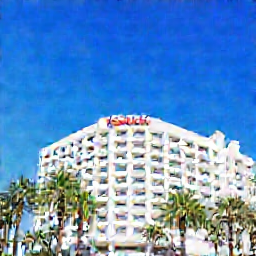

: 

In [ ]:
from PIL import Image
image = ae.decode(z=torch.from_numpy(latent / ae.config.scaling_factor + ae.config.shift_factor).to(torch.bfloat16)).sample
image_np = ((image + 1) * 127).clip(0, 255).to(torch.uint8).numpy().squeeze().transpose(1, 2, 0)
image_pil = Image.fromarray(image_np)
image_pil

In [3]:
DISK_CACHE_DIR = Path(".dspy_cache")
DISK_CACHE_LIMIT = 1e10 # 10 GB

litellm.cache = Cache(disk_cache_dir=DISK_CACHE_DIR, type="disk")

if litellm.cache.cache.disk_cache.size_limit != DISK_CACHE_LIMIT:
    litellm.cache.cache.disk_cache.reset("size_limit", DISK_CACHE_LIMIT)

litellm.telemetry = False

# Turn off by default to avoid LiteLLM logging during every LM call.
litellm.suppress_debug_info = True

In [ ]:
response = completion(
  model="openai/google/gemini-2.0-flash-exp",
  messages=[{ "content": "Hello, how are you?","role": "user"}],
  base_url="https://openrouter.ai/api/v1",
)

print(response.usage)

NotFoundError: litellm.NotFoundError: NotFoundError: OpenAIException - Error code: 404 - {'error': {'message': 'No endpoints found for google/gemini-2.0-flash-exp.', 'code': 404}, 'user_id': 'user_2roQBGb2Yv9TCHgKuKkQUJTaXkG'}

In [ ]:



# Path to your image
image_path = "test.jpg"

# Getting the Base64 string
base64_image = encode_image(image_path)

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What is in this image?",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ],
        }
    ],
)

In [18]:
from PIL import Image
import io

def encode_image(image_pil: Image):
    png_bytes = io.BytesIO()
    image_pil.save(png_bytes, format="PNG")
    return base64.b64encode(png_bytes.getvalue()).decode("utf-8")

base64_image = encode_image(Image.open("cat.jpeg"))
messages = [{
    "role": "user",
    "content": [{
        "type": "text",
        "text": "Describe this image"
    }, {
        "type": "image_url",
        "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
        }
    }]
}]

In [20]:
response = completion(
  model="openai/google/gemini-2.0-flash-001",
  messages=messages,
  base_url="https://openrouter.ai/api/v1",
)

print(response.choices[0])

Choices(finish_reason='stop', index=0, message=Message(content="Here is a description of the image:\n\nA captivating square, medium shot depicts an irresistibly charming kitten, poised just above the top of what appears to be a furry or fuzzy container. From the kitten's chest up is visible, with a dark, out-of-focus background behind it.\n\nThe kitten's fur is a subtly muted ivory color, giving it a creamy, delicate look. Its eyes, a vivid blue, are the focal point of the photograph, drawing one's attention to the kitten's expressive gaze, directed to the upper right of the frame. The kitten's nose and mouth are shades of a light pink. The whiskers are a light and soft pink. The ears are both pointy.\n\nBelow the kitten, the leopard-print base adds texture and pattern to the image. This contrast between the kitten's soft fur and the patterned background creates a visually interesting composition.\n\nOverall, the image evokes a sense of warmth, tenderness, and innocence, capturing the 